```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

Producing plots of data assimilation experiments by post-processing the
files produced by scripts/run_experiment.py

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Post Processing of Data Assimilation experiments

## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import os
import sys
import datetime

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import IPythonMagic, SimReader, Observation, ParticleInfo

In [2]:
%cuda_context_handler gpu_ctx
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")


In [3]:
#Create output directory for images
#imgdir = 'double_jet'
#filename_prefix = imgdir + "/" + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S") + "_"
#os.makedirs(imgdir, exist_ok=True)
#print("Saving images to " + imgdir)

### Define functions for plotting

In [4]:
def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12,3), 
            interior=False, color_bar_from_zero=False):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    eta_max = np.max(np.abs(eta))
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    eta_min = -eta_max
    huv_min = -huv_max
    if color_bar_from_zero:
        eta_min, huv_min = 0, 0
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=eta_min, vmax=eta_max)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=eta_min, vmax=eta_max)
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max)
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max)
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    
def plotDrifters(observations, sim_reader, t, drifter_set=[]):
    drifter_positions = observations.get_drifter_position(t)

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    nx, ny = sim_reader.get('nx'), sim_reader.get('ny')
    dx, dy = sim_reader.get('dx'), sim_reader.get('dy')

    emptyData =np.ma.masked_where(np.zeros((ny,nx)) > 1, np.zeros((ny,nx)))
    ax.imshow(emptyData, origin="lower", extent=[0, nx*dx, 0, ny*dy], cmap='binary')

    for i in range(drifter_positions.shape[0]):
        color = 'xkcd:pale cyan'
        if i in drifter_set:
            color = 'xkcd:tomato red'
        circ_end = matplotlib.patches.Circle((drifter_positions[i,0], drifter_positions[i,1]),
                                             3000, fill=True, zorder=10, color=color)
        ax.add_patch(circ_end)

    
def days_to_sec(days):
    return days*24*60*60

def sec_to_days(secs):
    return secs/(24*60*60)

def truth_time_step(t):
    t = t - days_to_sec(3)
    return int(t/(60*60))

## Specify the folder containing the results

In [5]:
result_dir = os.path.abspath('scripts/da_experiment_2019_05_06-14_35_19_IEWPF2s_success/')

In [59]:
def file_filter(path_to_dir, ext=None, prefix=None, abspath=True):
    filtered_files = os.listdir(path_to_dir)
    if prefix:
        filtered_files = list(file for file in filtered_files if file.startswith(prefix))
    if ext:
        filtered_files = list(file for file in filtered_files if file.endswith(ext))
    if abspath:
        filtered_files= list(os.path.join(path_to_dir, file)  for file in filtered_files)

    filtered_files.sort()
    return filtered_files


nc_files = file_filter(result_dir, ext='nc')
obs_files = file_filter(result_dir, ext='bz2', prefix='forecast')
particle_info_files = file_filter(result_dir, ext='bz2', prefix='particle_info')
print("number of nc_files:            ", len(nc_files))
print("number of obs_files:           ", len(obs_files))
print("number of particle_info_files: ", len(particle_info_files))

if False:
    print(len(nc_files), nc_files)
    print()
    print(len(obs_files), obs_files)
    print()
    print(len(particle_info_files), particle_info_files)
    
# Truth:
true_nc = "double_jet_truth/double_jet_case_truth.nc"
true_obs_file = "double_jet_truth/drifter_observations.pickle"
    
ensemble_size = len(nc_files)
num_drifters=64

drifterSet = [4, 12, 20, 28, 36, 44, 52, 60]


number of nc_files:             100
number of obs_files:            98
number of particle_info_files:  700


# Mean and variance for different timesteps

In [7]:
# Read netCDF files
reload(SimReader)

truth_reader = SimReader.SimNetCDFReader(true_nc)
sim_readers = [None]*ensemble_size
for particle_id in range(ensemble_size):
    sim_readers[particle_id] = SimReader.SimNetCDFReader(nc_files[particle_id])


In [8]:
# Printing the timestamps for particle zero:
example_sim_reader = sim_readers[0]
times = example_sim_reader.getTimes()
print(times.data/(3600*24))
print('Hopefully these values are only full days')


[ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]
Hopefully these values are only full days


Found nan for particle 80
Found nan for particle 16
Found nan for particle 21
Found nan for particle 78
Found nan for particle 16
Found nan for particle 21
Found nan for particle 78


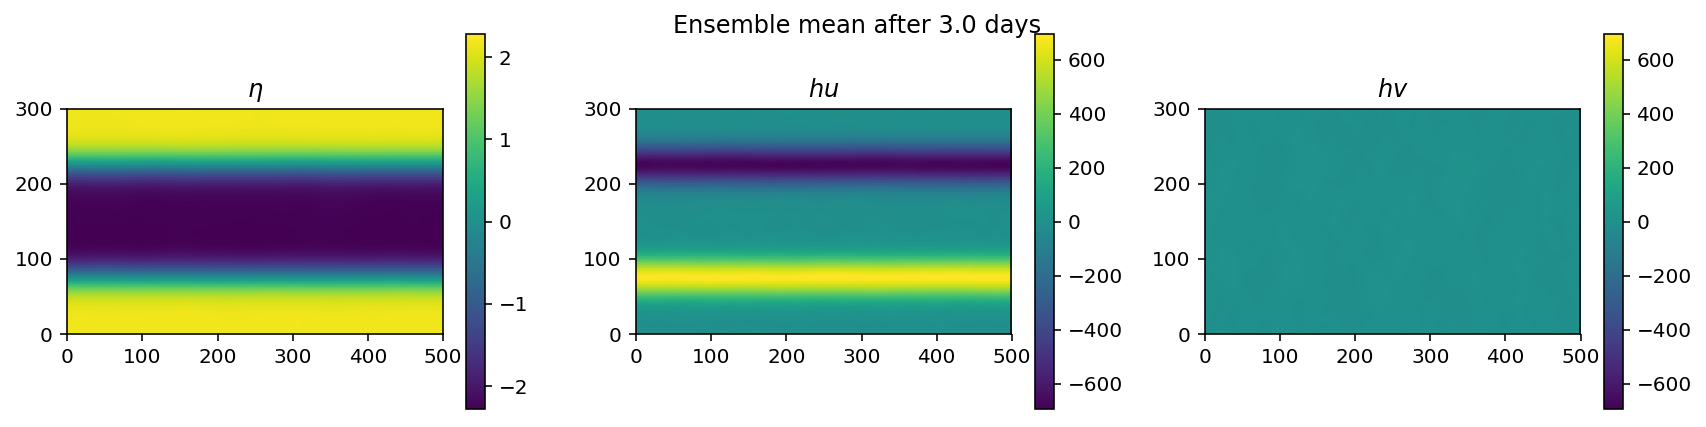

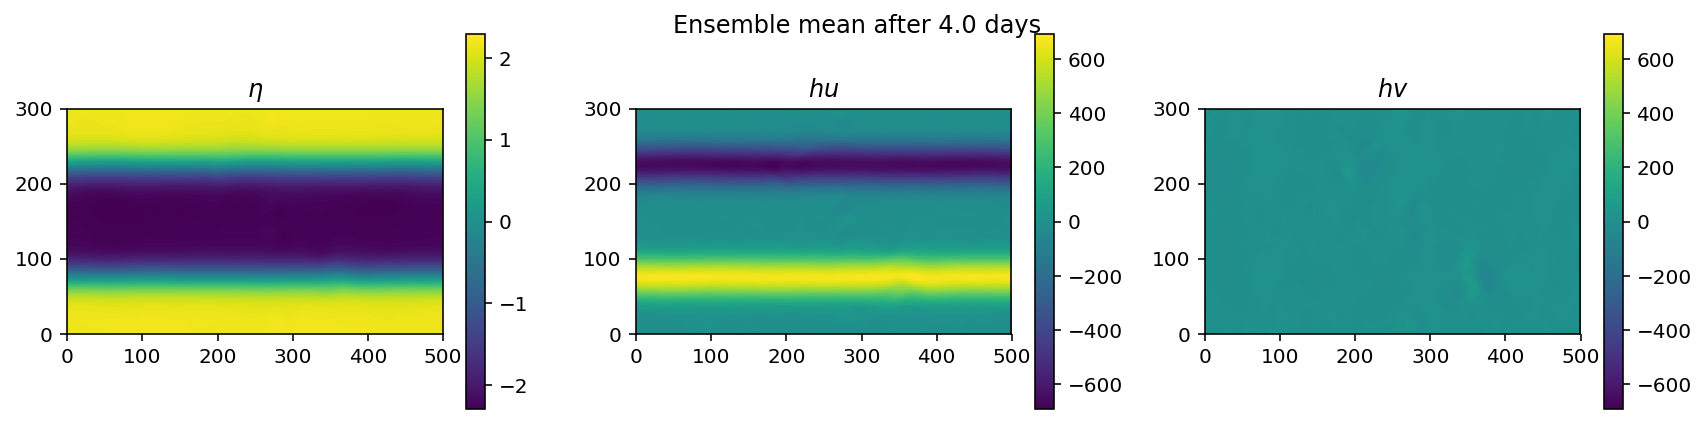

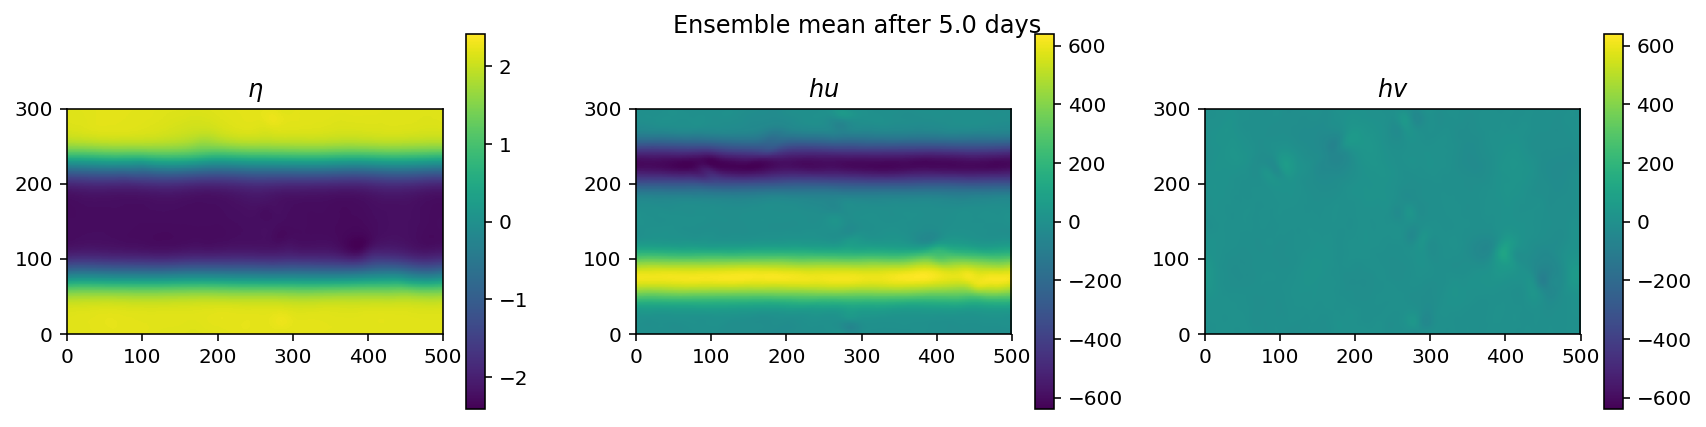

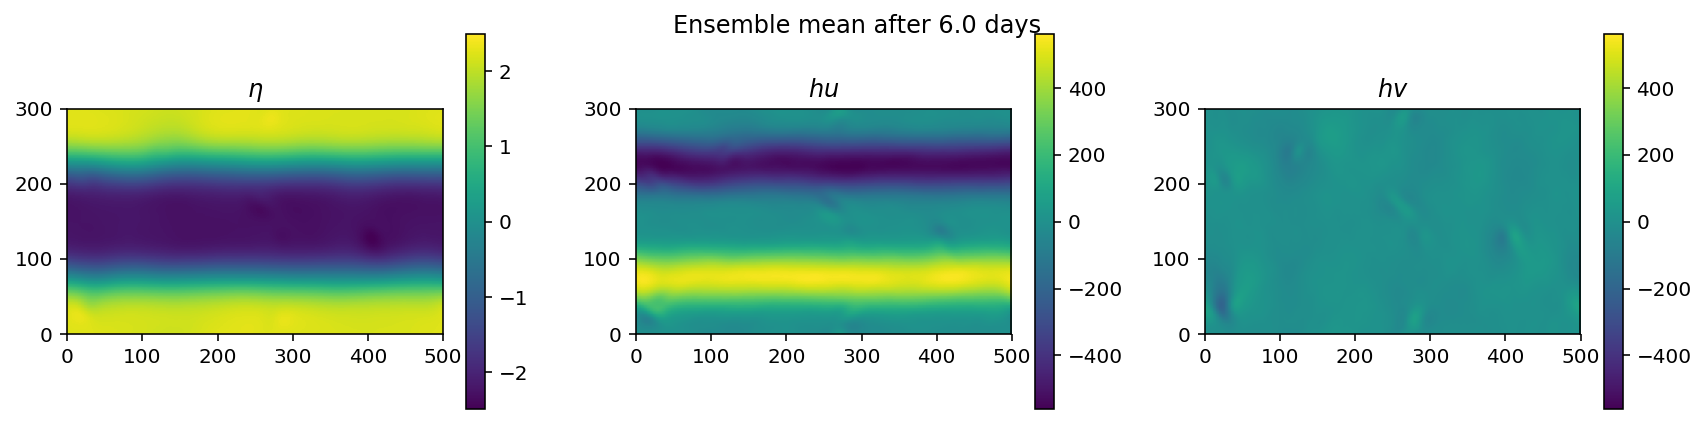

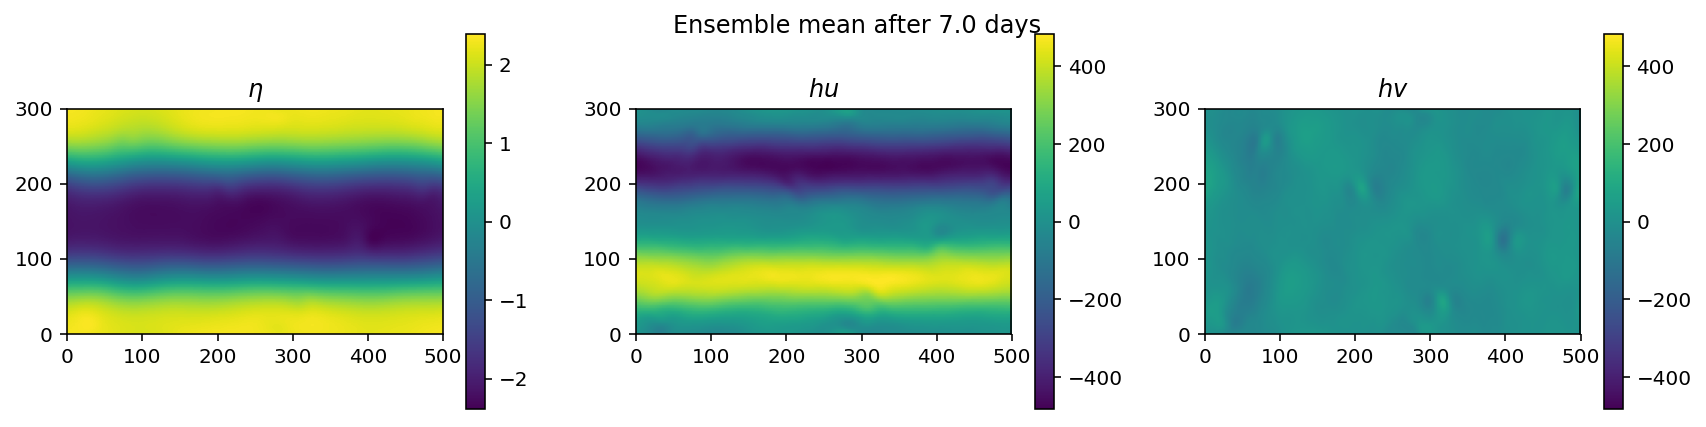

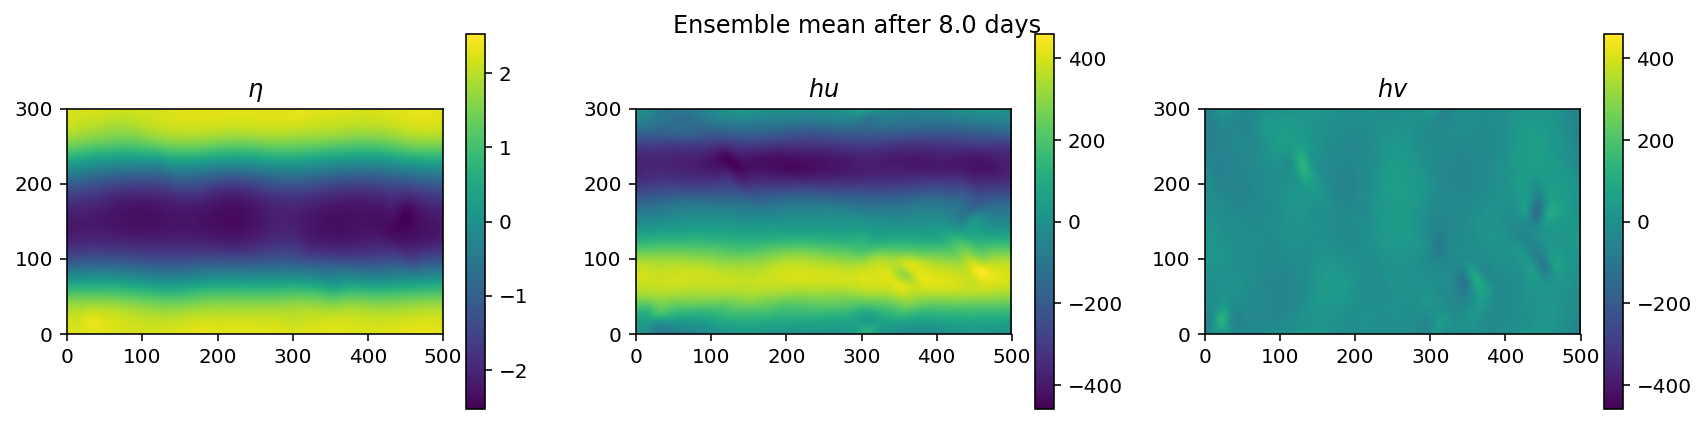

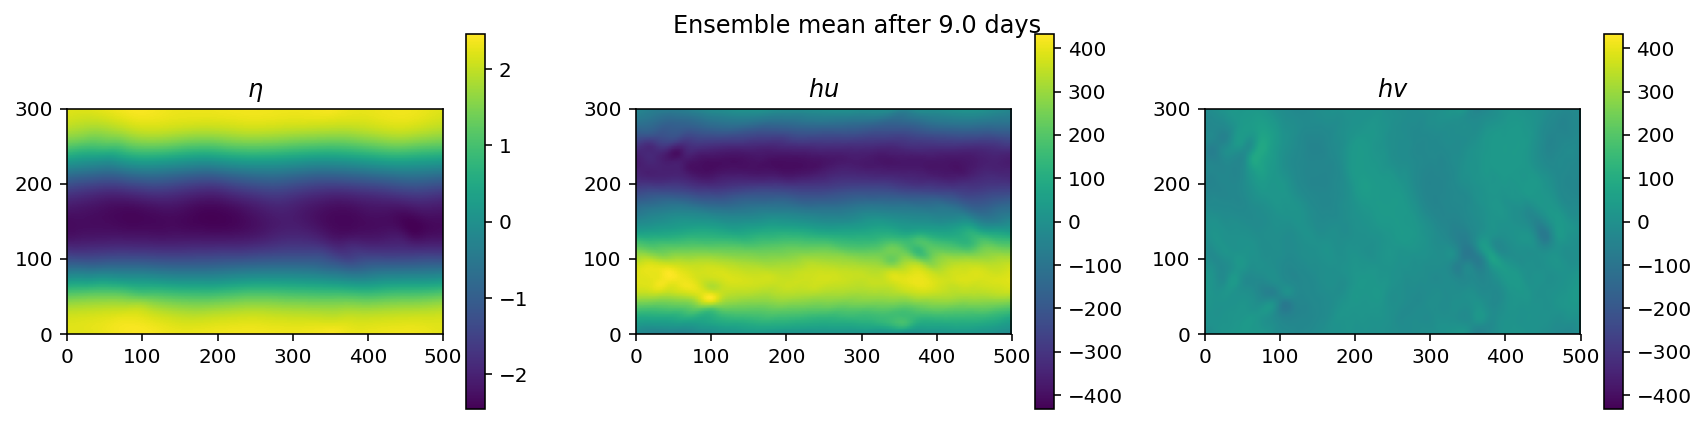

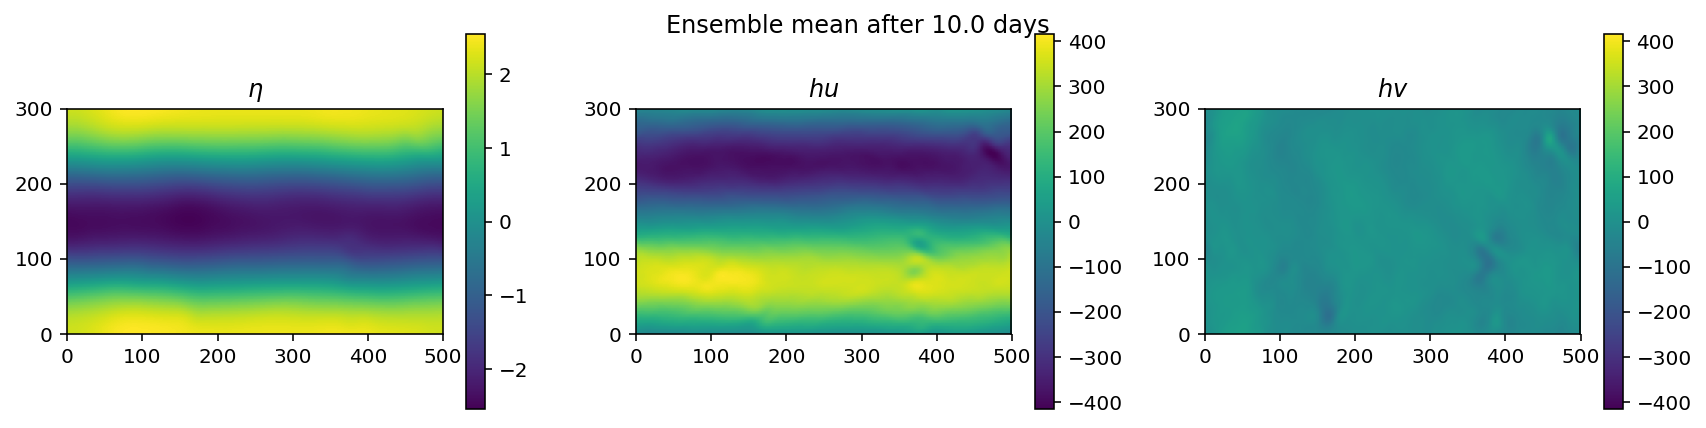

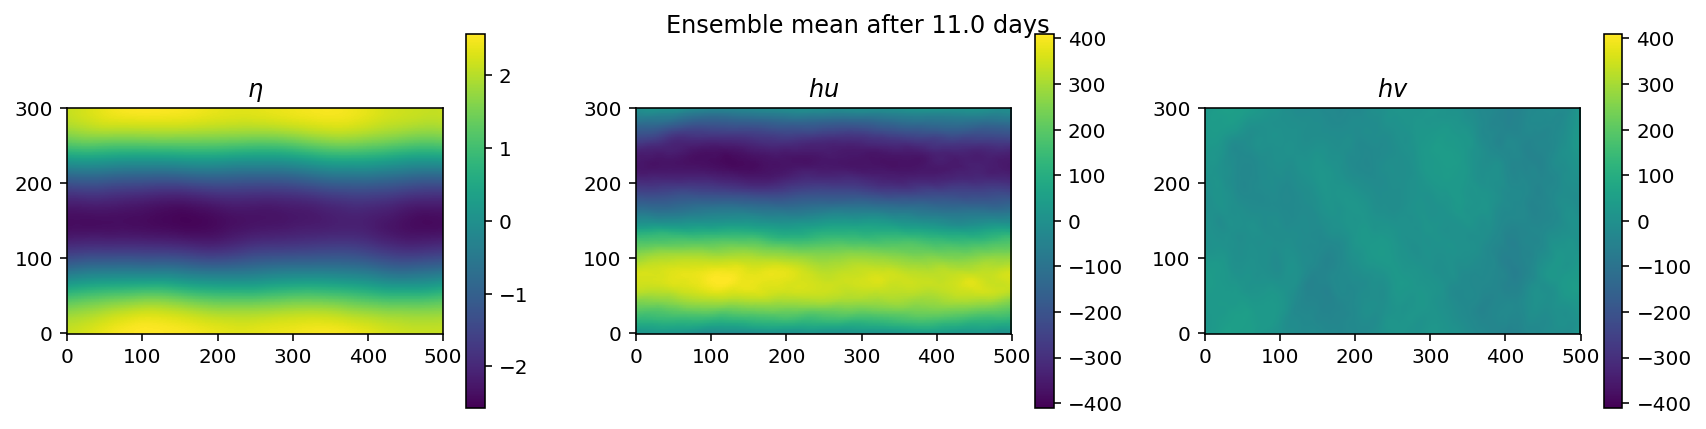

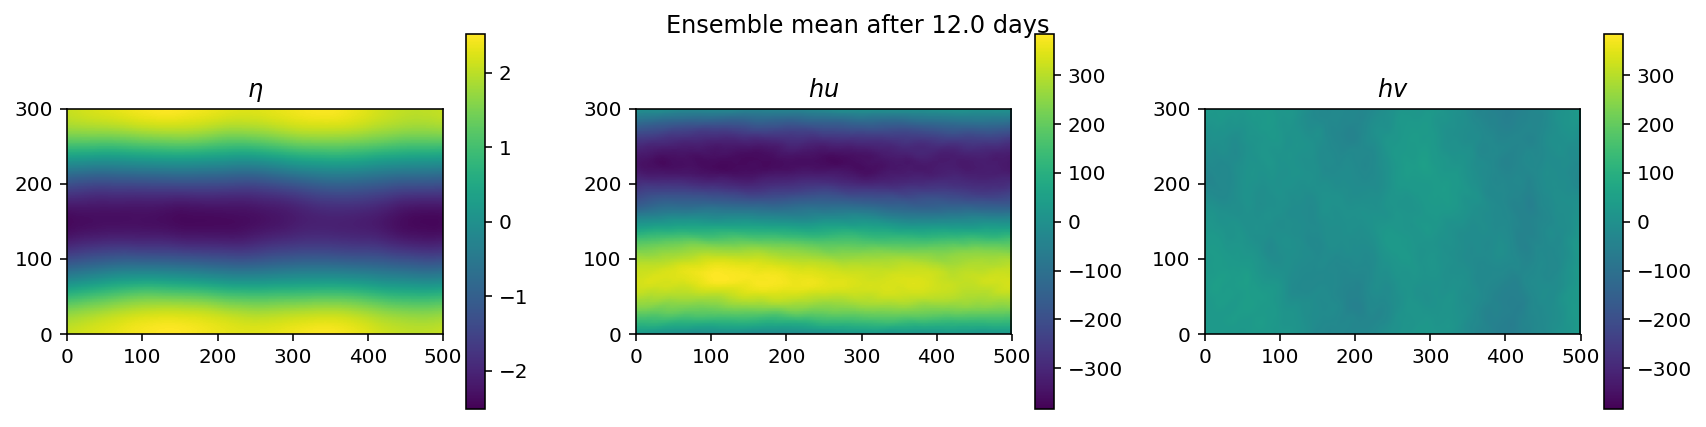

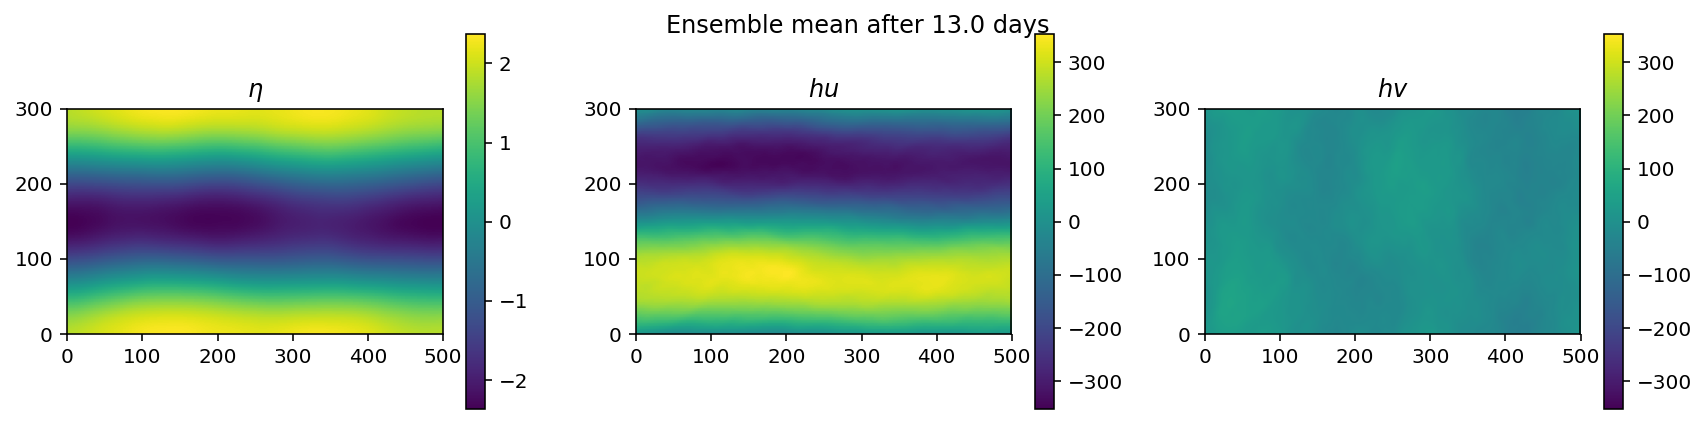

In [9]:

for t in times:
    true_eta, true_hu, true_hv, t_tmp = truth_reader.getStateAtTime(t)
    #imshow3(true_eta, true_hu, true_hv, title='True state after ' + str(sec_to_days(t)) + ' days')
    
    mean_eta, mean_hu, mean_hv = np.zeros_like(true_eta), np.zeros_like(true_hu), np.zeros_like(true_hv)
    var_eta, var_hu, var_hv = np.zeros_like(true_eta), np.zeros_like(true_hu), np.zeros_like(true_hv)
    rmse_eta, rmse_hu, rmse_hv = np.zeros_like(true_eta), np.zeros_like(true_hu), np.zeros_like(true_hv)
    actual_ensemble_size = 0
    for particle in sim_readers:
        try:
            eta, hu, hv, t_tmp = particle.getStateAtTime(t)
            if np.any(np.isnan(eta)):
                print("Found nan for particle " + str(actual_ensemble_size))
                raise RuntimeError()
            mean_eta += eta
            mean_hu += hu
            mean_hv += hv
            var_eta += eta*eta
            var_hu += hu*hu
            var_hv += hv*hv
            actual_ensemble_size += 1
        except RuntimeError:
            pass
            # Ignore not found RuntimeError
    mean_eta /= actual_ensemble_size
    mean_hu /= actual_ensemble_size
    mean_hv /= actual_ensemble_size
    
    var_eta = var_eta/actual_ensemble_size - mean_eta*mean_eta
    var_hu  = var_hu/actual_ensemble_size -mean_hu*mean_hu
    var_hv  = var_hv/actual_ensemble_size -mean_hv*mean_hv
    
    
    
    imshow3(mean_eta, mean_hu, mean_hv, title='Ensemble mean after ' + str(sec_to_days(t)) + ' days')
    #imshow3(mean_eta-true_eta, mean_hu-true_hu, mean_hv-true_hv, \
    #        title='Error after ' + str(sec_to_days(t)) + ' days')
    #imshow3(var_eta, var_hu, var_hv, 
    #        title='Variance after ' + str(sec_to_days(t)) + ' days', color_bar_from_zero=True)
    
    if False:
        var2_eta, var2_hu, var2_hv = np.zeros_like(true_eta), np.zeros_like(true_hu), np.zeros_like(true_hv)
        actual_ensemble_size = 0
        for particle in sim_readers:
            try:
                eta, hu, hv, t_tmp = particle.getStateAtTime(t)
                var2_eta += (mean_eta - eta)**2
                var2_hu += (mean_hu - hu)**2
                var2_hv += (mean_hv - hv)**2
                actual_ensemble_size += 1
            except RuntimeError:
                pass
                # Ignore not found RuntimeError

        var2_eta = np.sqrt(var2_eta)/(actual_ensemble_size - 1)
        var2_hu  = np.sqrt(var2_hu)/(actual_ensemble_size - 1)
        var2_hv  = np.sqrt(var2_hv)/(actual_ensemble_size - 1)
        #imshow3(var2_eta, var2_hu, var2_hv, 
        #        title='Variance (2) after ' + str(sec_to_days(t)) + ' days', color_bar_from_zero=True)


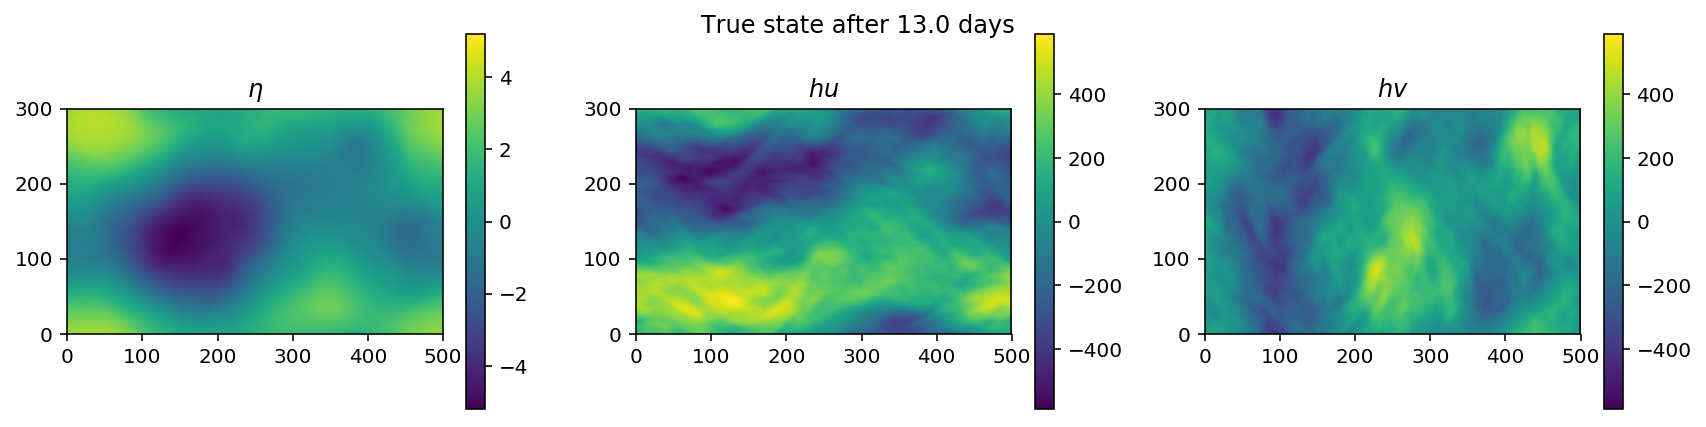

In [10]:
imshow3(true_eta, true_hu, true_hv, title='True state after ' + str(sec_to_days(t)) + ' days')


# Variance under drifters


In [11]:
num_particles = len(nc_files)
num_days = 7

particle_infos = [None]*num_particles

for particle in range(num_particles):
    filenames = file_filter(result_dir, ext='bz2', 
                            prefix='particle_info_' + str(particle).zfill(4))
    infos = [None]*num_days
    for day in range(num_days):
        infos[day] = ParticleInfo.ParticleInfo()
        infos[day].read_pickle(filenames[day])
        if particle == 0:
            print(filenames[day])
    particle_infos[particle] = infos
    
#print(particle_infos)

/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/DAPaper/scripts/da_experiment_2019_05_06-14_35_19_IEWPF2s_success/particle_info_0000_00.bz2
/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/DAPaper/scripts/da_experiment_2019_05_06-14_35_19_IEWPF2s_success/particle_info_0000_01.bz2
/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/DAPaper/scripts/da_experiment_2019_05_06-14_35_19_IEWPF2s_success/particle_info_0000_02.bz2
/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/DAPaper/scripts/da_experiment_2019_05_06-14_35_19_IEWPF2s_success/particle_info_0000_03.bz2
/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/DAPaper/scripts/da_experiment_2019_05_06-14_35_19_IEWPF2s_success/particle_info_0000_04.bz2
/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/DAPaper/scripts/da_experiment_2019_05_06-14_35_19_IEWPF2s_success/particle_info_0000_05.bz2
/home/havahol/playground/gpu-ocean

In [12]:
    
info_example = particle_infos[0][0]

In [13]:
filenames = file_filter(result_dir, ext='bz2', 
                            prefix='particle_info_' + str(0).zfill(4))
for filename in filenames:
    print(filename)
print(".........")
filenames.sort()
for filename in filenames:
    print(filename)

/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/DAPaper/scripts/da_experiment_2019_05_06-14_35_19_IEWPF2s_success/particle_info_0000_00.bz2
/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/DAPaper/scripts/da_experiment_2019_05_06-14_35_19_IEWPF2s_success/particle_info_0000_01.bz2
/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/DAPaper/scripts/da_experiment_2019_05_06-14_35_19_IEWPF2s_success/particle_info_0000_02.bz2
/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/DAPaper/scripts/da_experiment_2019_05_06-14_35_19_IEWPF2s_success/particle_info_0000_03.bz2
/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/DAPaper/scripts/da_experiment_2019_05_06-14_35_19_IEWPF2s_success/particle_info_0000_04.bz2
/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/DAPaper/scripts/da_experiment_2019_05_06-14_35_19_IEWPF2s_success/particle_info_0000_05.bz2
/home/havahol/playground/gpu-ocean

In [14]:
var_per_day = [None]*num_days

#for day in range(num_days):

sample_times = info_example.get_sample_times()

drifter_id = 4

variance_eta_first_day = np.zeros((num_drifters,len(sample_times)))
variance_hu_first_day = np.zeros((num_drifters,len(sample_times)))
variance_hv_first_day = np.zeros((num_drifters,len(sample_times)))

mean_eta_first_day = np.zeros((num_drifters,len(sample_times)))
mean_hu_first_day = np.zeros((num_drifters,len(sample_times)))
mean_hv_first_day = np.zeros((num_drifters,len(sample_times)))

day = 2
for particle_id in range(num_particles):
    
    sample_file = 'particle_info_' + str(particle_id).zfill(4) + "_" + str(day).zfill(2) + ".bz2"
    sample_path = os.path.join(result_dir, sample_file)
    #"particle_info_0000_06.bz2"
    
    try:

        info = ParticleInfo.ParticleInfo()
        info.read_pickle(sample_path)

        for t_id in range(len(sample_times)):

            time = sample_times[t_id] + days_to_sec(day)

            state_samples = info.get_state_samples(time)

            #state_samples = particle_infos[particle_id][0].get_state_samples(sample_times[t_id])

            for drifter_id in range(num_drifters):
                mean_eta_first_day[drifter_id, t_id] += state_samples[drifter_id, 0]
                mean_hu_first_day[drifter_id, t_id] += state_samples[drifter_id, 1]
                mean_hv_first_day[drifter_id, t_id] += state_samples[drifter_id, 2]

                variance_eta_first_day[drifter_id, t_id] += state_samples[drifter_id, 0]**2
                variance_hu_first_day[drifter_id, t_id] += state_samples[drifter_id, 1]**2
                variance_hv_first_day[drifter_id, t_id] += state_samples[drifter_id, 2]**2

        print("."+str(particle_id)+".", end='')
        
        
    
    except AssertionError as ae:
        print('\nParticle ' + str(particle_id) + ' failed')
        print(ae)
        
    
        
            
            
mean_eta_first_day /= num_particles
mean_hu_first_day /= num_particles
mean_hv_first_day /= num_particles        
        
variance_eta_first_day = variance_eta_first_day/num_particles - mean_eta_first_day**2
variance_hu_first_day = variance_hu_first_day/num_particles - mean_hu_first_day**2
variance_hv_first_day = variance_hv_first_day/num_particles - mean_hv_first_day**2



.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78.
Particle 79 failed
State sample for time 432060.0 does not exists in DataFrame
.80..81..82..83..84..85..86..87..88..89..90..91..92.
Particle 93 failed
State sample for time 432060.0 does not exists in DataFrame
.94..95..96..97..98..99.

225

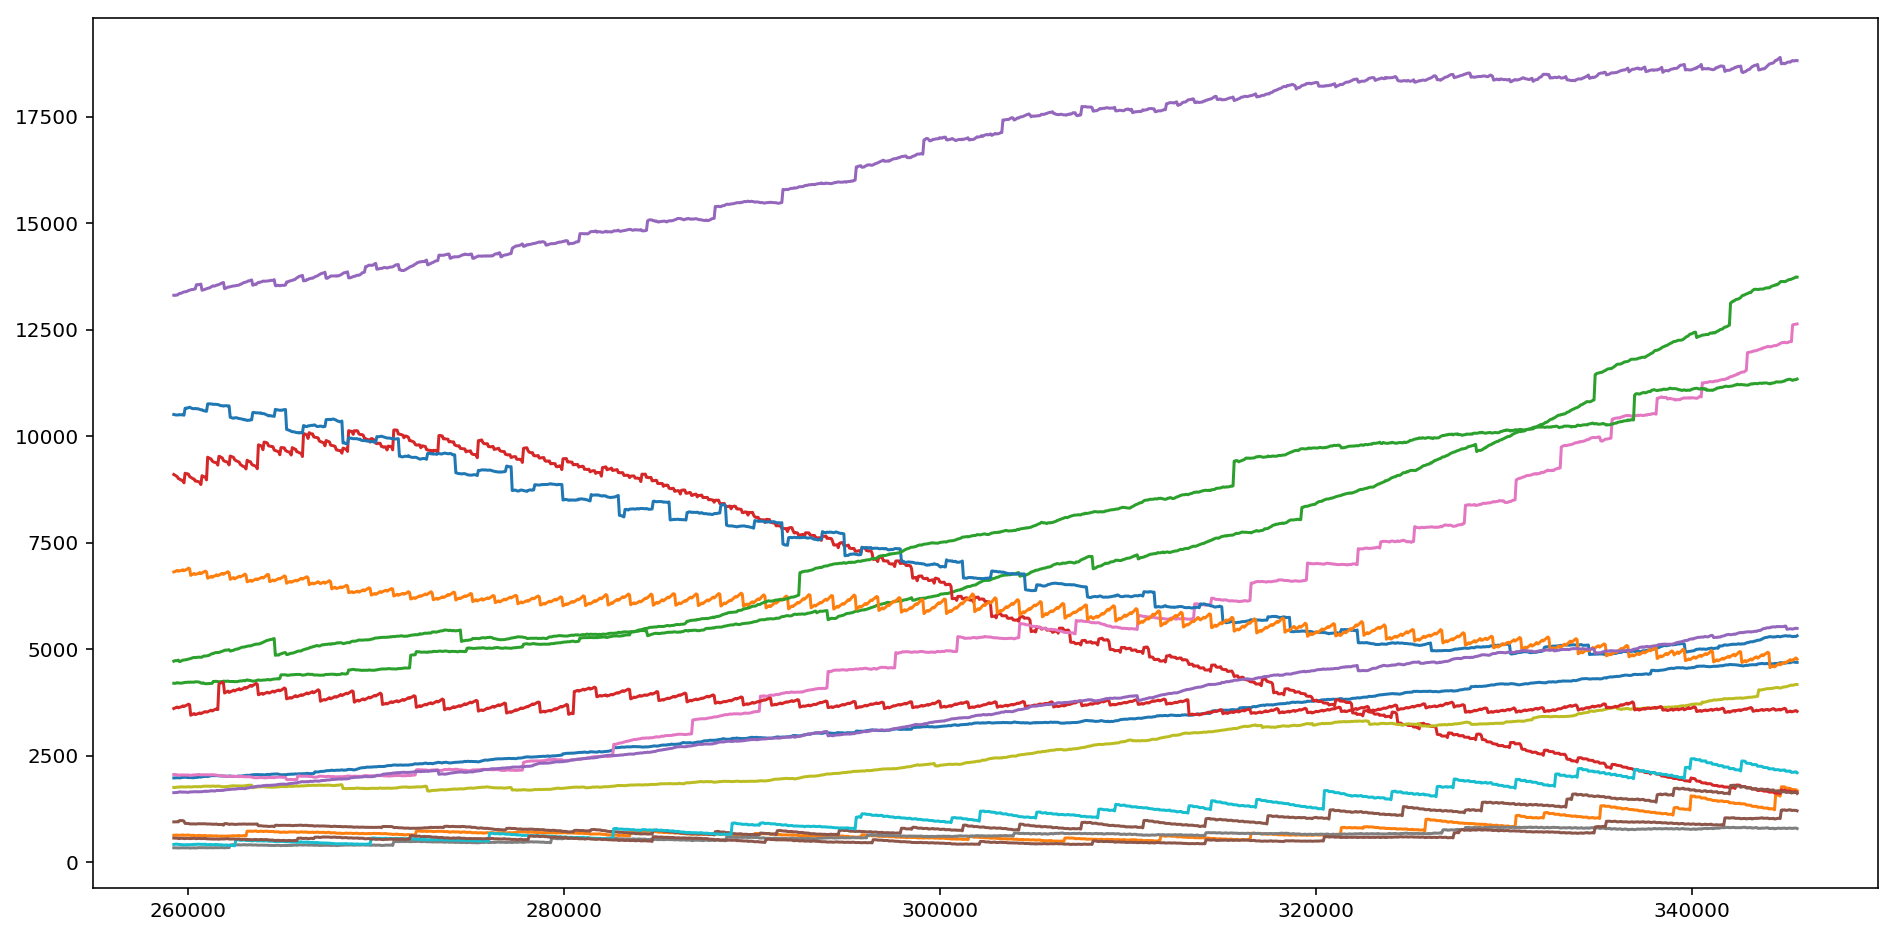

In [15]:
fig = plt.figure(figsize=(16,8))
for drifter_id in range(0, 64, 4):
    plt.plot(sample_times, variance_hu_first_day[drifter_id,:])
#plt.plot(sample_times, variance_hv_first_day[4,:])
#plt.plot(sample_times, variance_eta_first_day[4,:])
15*15

225

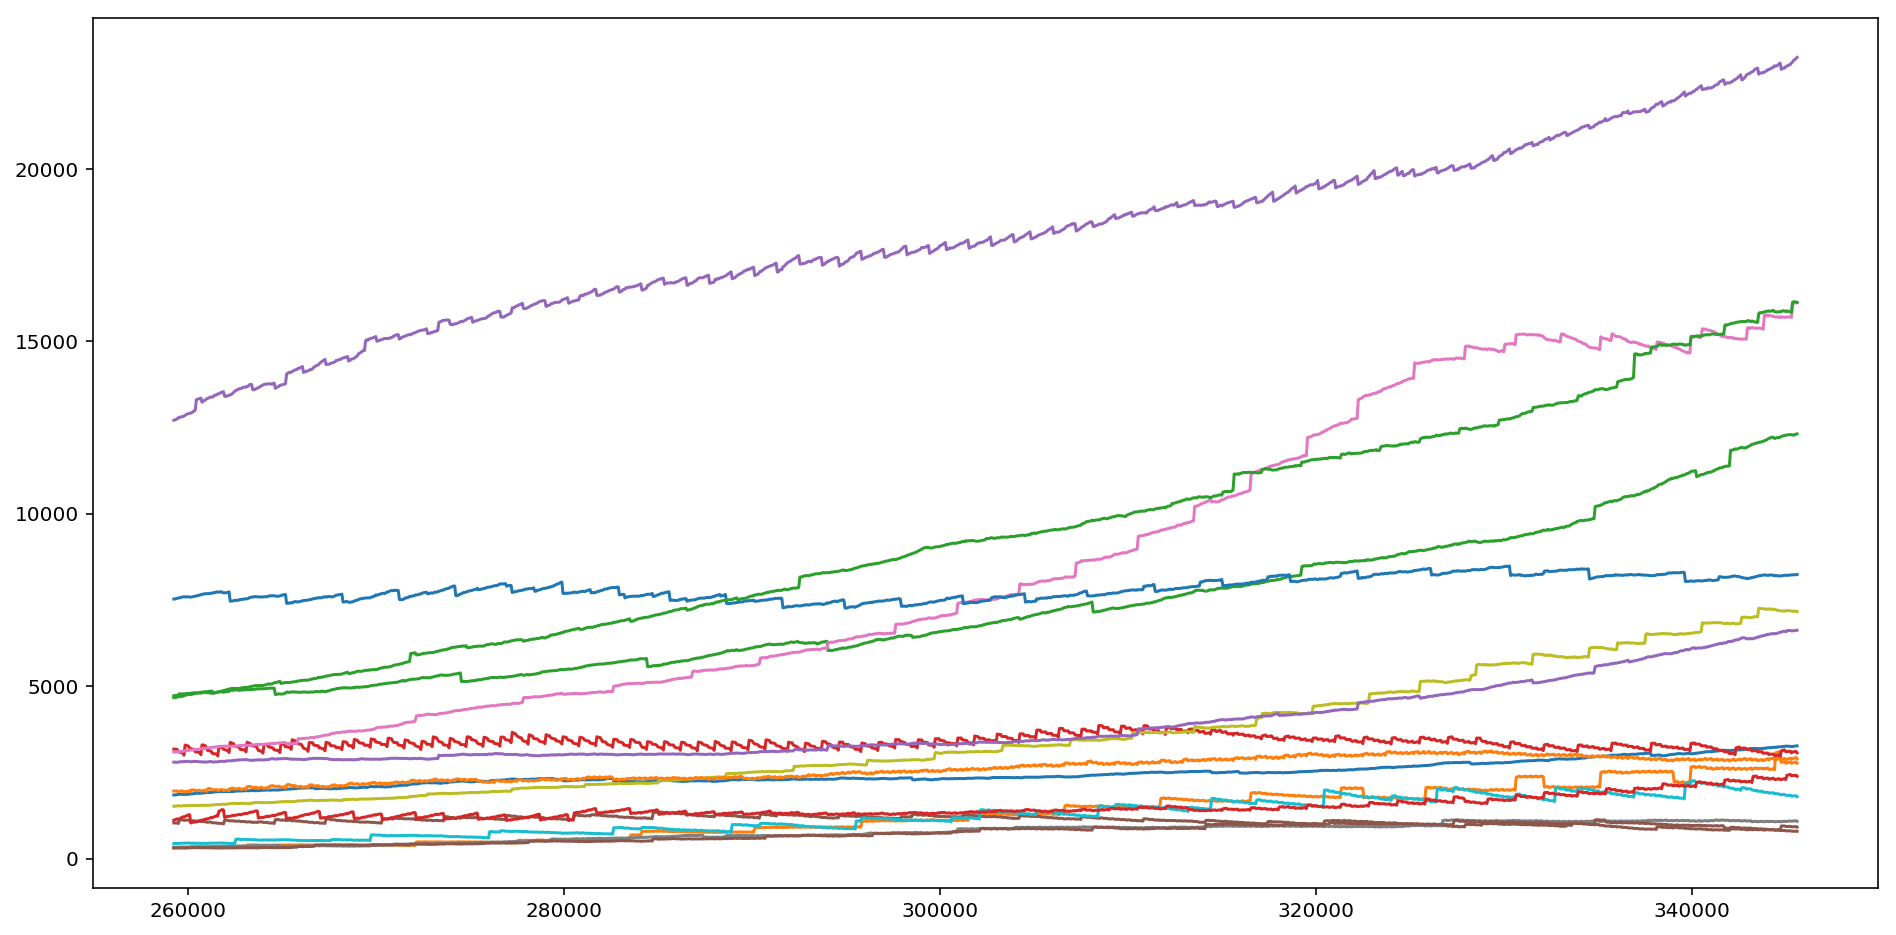

In [16]:
fig = plt.figure(figsize=(16,8))
for drifter_id in range(0, 64, 4):
    plt.plot(sample_times, variance_hv_first_day[drifter_id,:])
#plt.plot(sample_times, variance_hv_first_day[4,:])
#plt.plot(sample_times, variance_eta_first_day[4,:])
15*15

225

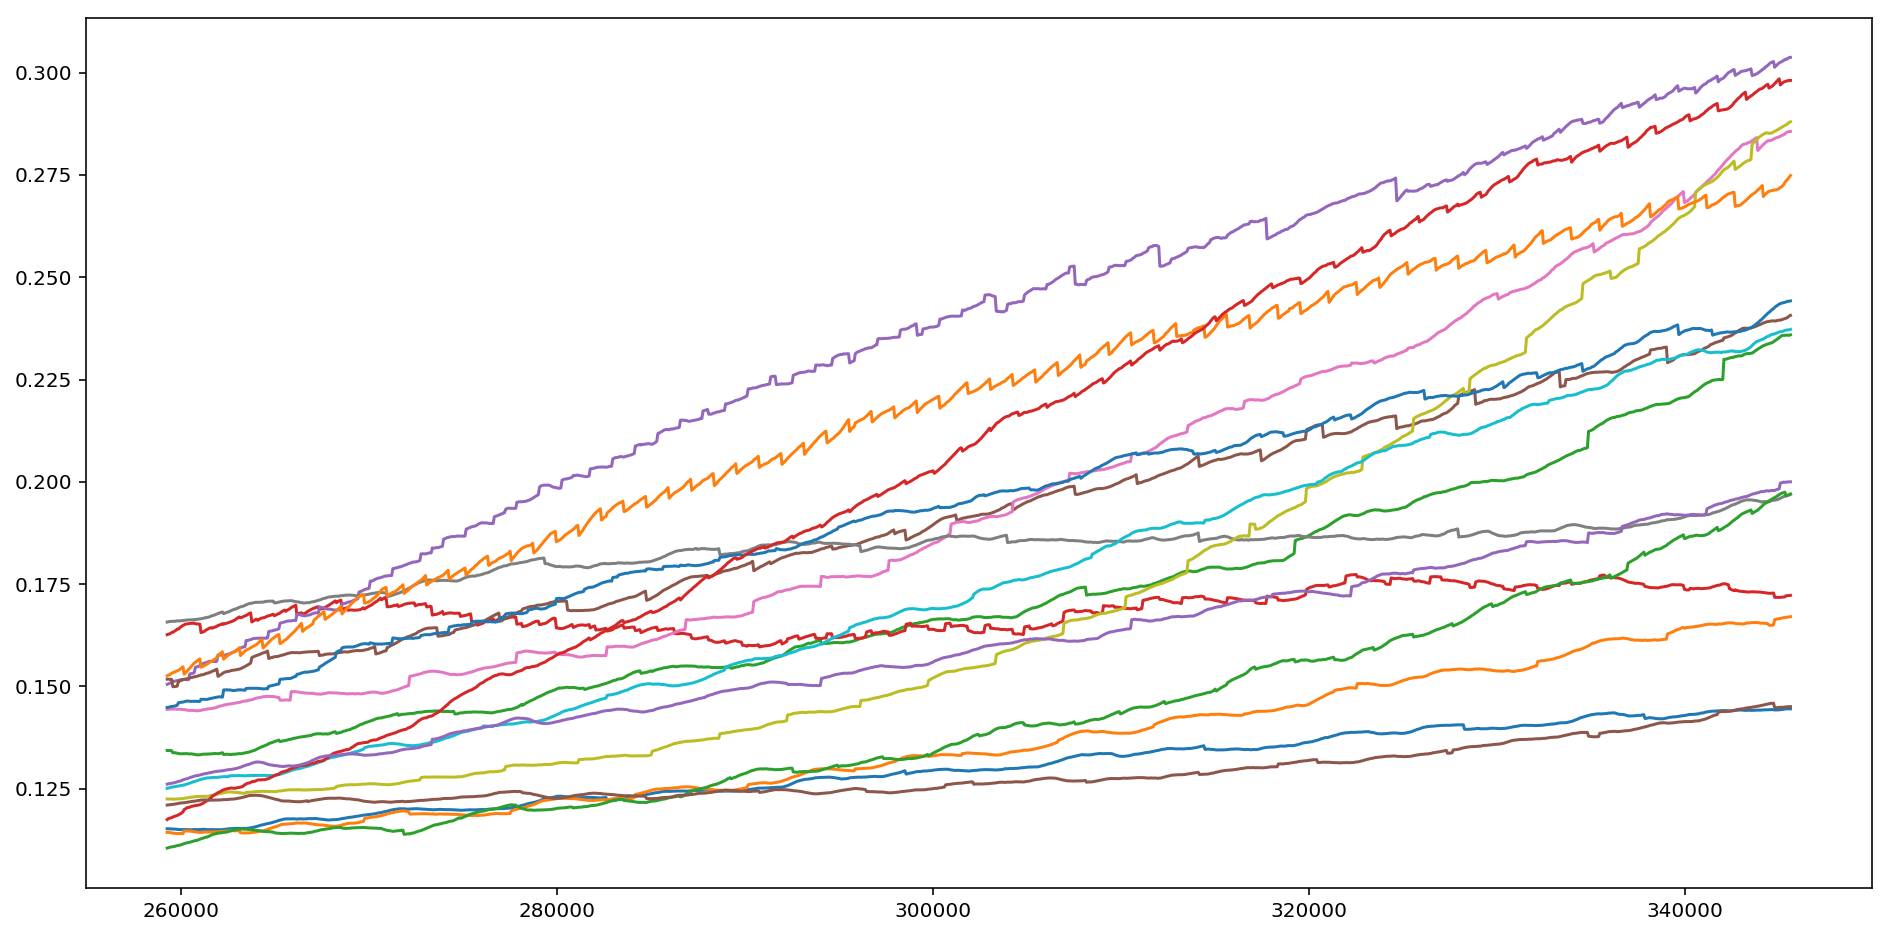

In [17]:
fig = plt.figure(figsize=(16,8))
for drifter_id in range(0, 64, 4):
    plt.plot(sample_times, variance_eta_first_day[drifter_id,:])
#plt.plot(sample_times, variance_hv_first_day[4,:])
#plt.plot(sample_times, variance_eta_first_day[4,:])
15*15

In [18]:
particle_infos[5][0].state_df

time                                state_under_drifter extra_states
0     259260.0  [[2.1845827102661133, 40.864418029785156, -36....         None
1     259320.0  [[2.1852622032165527, 41.686275482177734, -36....         None
2     259380.0  [[2.186490535736084, 41.37477111816406, -35.79...         None
3     259440.0  [[2.187126874923706, 42.14535903930664, -35.84...         None
4     259500.0  [[2.1875016689300537, 43.067657470703125, -36....         None
5     259560.0  [[2.1878228187561035, 42.67557144165039, -36.2...         None
6     259620.0  [[2.1876296997070312, 42.32759094238281, -36.2...         None
7     259680.0  [[2.187377452850342, 42.3261833190918, -36.248...         None
8     259740.0  [[2.1875381469726562, 42.51011276245117, -36.1...         None
9     259800.0  [[2.1872220039367676, 42.981082916259766, -36....         None
10    259860.0  [[2.1866796016693115, 42.347434997558594, -36....         None
11    259920.0  [[2.1858410835266113, 42.41001892089844, -36.2...         None
12    259980.0  [[2.185318946838379, 42.009132385253906, -36.2...         None
13    260040.0  [[2.1845486164093018, 41.59621047973633, -36.5...         None
14    260100.0  [[2.183845043182373, 41.310768127441406, -36.5...         None
15    260160.0  [[2.1830594539642334, 41.94249725341797, -36.5...         None
16    260220.0  [[2.1813721656799316, 41.433170318603516, -37....         None
17    260280.0  [[2.1805641651153564, 41.211944580078125, -37....         None
18    260340.0  [[2.1803653240203857, 41.66638946533203, -37.1...         None
19    260400.0  [[2.1795074939727783, 41.57404327392578, -37.5...         None
20    260460.0  [[2.178417205810547, 41.86971664428711, -38.37...         None
21    260520.0  [[2.1775596141815186, 41.83658981323242, -38.6...         None
22    260580.0  [[2.1759912967681885, 41.85049819946289, -39.0...         None
23    260640.0  [[2.1765902042388916, 42.22434997558594, -39.7...         None
24    260700.0  [[2.1776492595672607, 43.993019104003906, -39....         None
25    260760.0  [[2.178237199783325, 44.13984680175781, -38.92...         None
26    260820.0  [[2.1789722442626953, 43.89222717285156, -38.6...         None
27    260880.0  [[2.178719997406006, 43.05748748779297, -39.03...         None
28    260940.0  [[2.1783318519592285, 42.99139404296875, -39.8...         None
29    261000.0  [[2.178859233856201, 43.800201416015625, -39.1...         None
...        ...                                                ...          ...
1410  343860.0  [[2.190642833709717, -3.346060276031494, -28.9...         None
1411  343920.0  [[2.191415548324585, -3.8867530822753906, -29....         None
1412  343980.0  [[2.192290782928467, -3.879831075668335, -29.1...         None
1413  344040.0  [[2.192574977874756, -4.317256450653076, -29.2...         None
1414  344100.0  [[2.19234561920166, -4.58786678314209, -28.526...         None
1415  344160.0  [[2.191551685333252, -4.8927178382873535, -28....         None
1416  344220.0  [[2.190838575363159, -4.57589054107666, -28.81...         None
1417  344280.0  [[2.190596103668213, -4.587718486785889, -28.5...         None
1418  344340.0  [[2.1898717880249023, -4.220566272735596, -28....         None
1419  344400.0  [[2.1897621154785156, -4.43906307220459, -27.7...         None
1420  344460.0  [[2.19059157371521, -4.609066009521484, -27.57...         None
1421  344520.0  [[2.1912012100219727, -4.508254051208496, -27....         None
1422  344580.0  [[2.191432237625122, -4.029392242431641, -27.1...         None
1423  344640.0  [[2.191187620162964, -4.233588218688965, -26.5...         None
1424  344700.0  [[2.191643714904785, -4.4836320877075195, -26....         None
1425  344760.0  [[2.1931605339050293, -4.691593647003174, -26....         None
1426  344820.0  [[2.1941399574279785, -4.549435615539551, -26....         None
1427  344880.0  [[2.1958651542663574, -4.999207019805908, -26....         None
1428  344940.0  [[2.197582244873047, -4.691662788391113, -26

# Forecasting

In [184]:
### Function for creating forecast plot

def createForecastCanvas(true_sim_reader, num_canvases=1):
    """
    true_sim_reader: The SimReader object containing nx, ny, etc
    """   
    
    nx = true_sim_reader.get('nx')
    ny = true_sim_reader.get('ny')
    dx = true_sim_reader.get('dx')
    dy = true_sim_reader.get('dy')
    
    emptyData =np.ma.masked_where(np.zeros((ny, nx)) > 1, 
                                      np.zeros((ny, nx)))
    
    if num_canvases == 1:
        fig = plt.figure(figsize=(7,7))
        ax = plt.subplot(111)
        
        ax.imshow(emptyData, origin="lower", 
                  extent=[0, nx*dx, 0, ny*dy], cmap='binary')

        return ax
    
    elif num_canvases < 4:
        fig, axs = plt.subplots(1,num_canvases, figsize=(7*num_canvases, 7))
    
        for ax in axs:
            ax.imshow(emptyData, origin="lower", 
                      extent=[0, nx*dx, 0, ny*dy], cmap='binary')
            ax.set_ylim([0, ny*dy])
            ax.set_xlim([0, nx*dx])
        
        return axs
    assert (num_canvases < 4), 'Function not implemented for more than 3 canvases'

def forecastPlot(ax, true_paths, ensemble_paths, color_id=0):
    """
    ax: Axis object to draw trajectories in
    true_path: A single list of paths that represents the truth
    ensemble_paths: Multiple lists of paths that represents the forecast
    color_id: integer representing a pre-defined color combination.
    """

    color_combinations = [
        # [true color, forecast color]
        ['xkcd:dark grey blue', 'xkcd:light blue grey'],
        ['xkcd:viridian', 'xkcd:foam green']
    ]
    
    assert(color_id < len(color_combinations)), 'Invalid color_id'
    
    true_color = color_combinations[color_id][0]
    forecast_color = color_combinations[color_id][1]

    # Plot forecast paths 
    for paths in ensemble_paths:
        for path in paths:
            ax.plot(path[:,0], path[:,1], color=forecast_color)
        
        # Mark end position of forecast
        end_position   = paths[-1][-1,:]
        circ_end_forecast = matplotlib.patches.Circle((end_position[0], end_position[1]), 
                                                          2000, fill=False, zorder=10)
        ax.add_patch(circ_end_forecast)

    
    # Plot true path
    for path in true_paths:
        ax.plot(path[:,0], path[:,1], color=true_color, zorder=5)

    # Mark start and end of true path
    start_pos = true_paths[0][0,:]
    end_pos   = true_paths[-1][-1,:]
    circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                           6000, fill=False, zorder=10)
    ax.add_patch(circ_start)
    circ_end = matplotlib.patches.Circle((end_pos[0], end_pos[1]), 
                                         6000, fill=False, zorder=10)
    ax.add_patch(circ_end)

    
def plotThreeDayForecast(true_observations, ensemble_observations, drifter_id):
    
    start_time_forecast = days_to_sec(10)
    true_drifter_id = drifterSet[drifter_id]
    
    axs = createForecastCanvas(truth_reader, 3)
    
    for forecast_days in range(1,4):
        title=  str(forecast_days) + ' days forecast for drifter ' + str(drifter_id)
        print('generating ' + title)
        end_time_forecast = days_to_sec(10+forecast_days)
        
        true_paths = true_observations.get_drifter_path(true_drifter_id, 
                                                        start_time_forecast,
                                                        end_time_forecast)

        forecast_paths = [None]*len(ensemble_observations)
        for i in range(len(forecast_paths)):
            forecast_paths[i] = ensemble_observations[i].get_drifter_path(drifter_id,  
                                                                          start_time_forecast,
                                                                          end_time_forecast)
        
        ax_id = forecast_days-1
        forecastPlot(axs[ax_id], true_paths, forecast_paths)
        axs[ax_id].set_title(title)




In [151]:
reload(Observation)

# Read truth observation file:
true_observations = Observation.Observation()
true_observations.read_pickle(true_obs_file)

# Read observation files from the ensemble:

ensemble_observations = [None]*len(obs_files)
for i in range(len(obs_files)):
    ensemble_observations[i] = Observation.Observation()
    ensemble_observations[i].read_pickle(obs_files[i])

In [172]:
#nc_files = file_filter(result_dir, ext='nc')
#obs_files = file_filter(result_dir, ext='bz2', prefix='forecast')
#particle_info_files = file_filter(result_dir, ext='bz2', prefix='particle_info')


start_time_forecast = days_to_sec(10)
end_time_forecast = days_to_sec(11)
obs_times = true_observations.get_observation_times()

drifter_id = 0
true_drifter_id = drifterSet[drifter_id]

print("Number of obs_times: ", len(obs_times))
print("Obs interval (s) (assuming 10 days): ", (10*24*60*60)/len(obs_times))
print("Day of first obs_time:  ", sec_to_days(obs_times[0]))
print("Day of second obs_time: ", sec_to_days(obs_times[1]))
print("Day of last obs_time:   ", sec_to_days(obs_times[-1]))

print("Time diff first to second (in s):        ", obs_times[1]-obs_times[0])
print("Time diff last to second to last (in s): ", obs_times[-1]-obs_times[-2])

print("Number of relevant time steps (3 day forecast): ", 3*len(obs_times)/10)

print('\nReading true path')
true_paths = true_observations.get_drifter_path(true_drifter_id, days_to_sec(10), end_time_forecast)
print('True path obtained')


print('\nReading ' + str(len(ensemble_observations)) + ' ensemble paths')
forecast_paths = [None]*len(ensemble_observations)
for i in range(len(forecast_paths)):
    forecast_paths[i] = ensemble_observations[i].get_drifter_path(drifter_id, days_to_sec(10), end_time_forecast)
    print("."+str(i)+".", end='')


    


Number of obs_times:  2880
Obs interval (s) (assuming 10 days):  300.0
Day of first obs_time:   3.0034722222222223
Day of second obs_time:  3.0069444444444446
Day of last obs_time:    13.0
Time diff first to second (in s):         300.0
Time diff last to second to last (in s):  300.0
Number of relevant time steps (3 day forecast):  864.0

Reading true path
True path obtained

Reading 98 ensemble paths
.0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97.

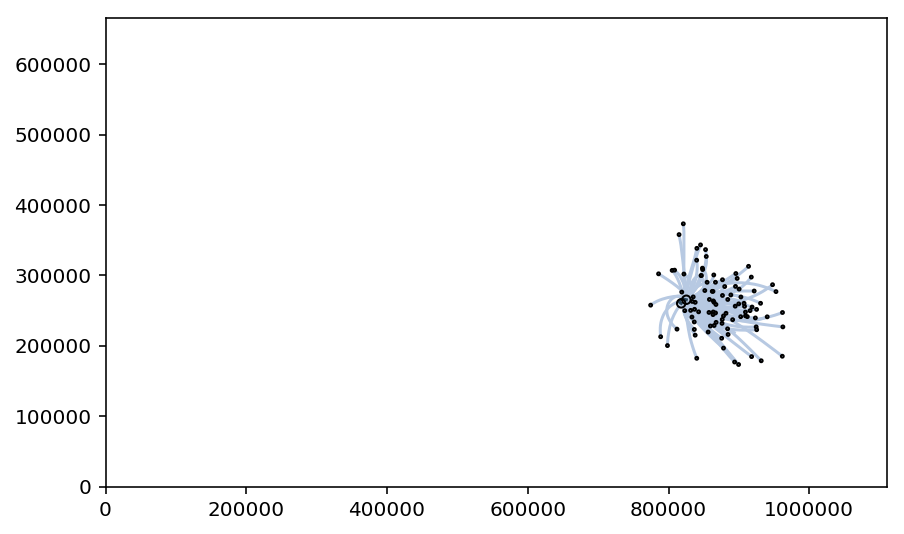

In [173]:
ax = createForecastCanvas(truth_reader)
forecastPlot(ax, true_paths, forecast_paths)



generating 1 days forecast for drifter 0
generating 2 days forecast for drifter 0
generating 3 days forecast for drifter 0
generating 1 days forecast for drifter 1
generating 2 days forecast for drifter 1
generating 3 days forecast for drifter 1
generating 1 days forecast for drifter 2
generating 2 days forecast for drifter 2
generating 3 days forecast for drifter 2
generating 1 days forecast for drifter 3
generating 2 days forecast for drifter 3
generating 3 days forecast for drifter 3
generating 1 days forecast for drifter 4
generating 2 days forecast for drifter 4
generating 3 days forecast for drifter 4
generating 1 days forecast for drifter 5
generating 2 days forecast for drifter 5
generating 3 days forecast for drifter 5
generating 1 days forecast for drifter 6
generating 2 days forecast for drifter 6
generating 3 days forecast for drifter 6
generating 1 days forecast for drifter 7
generating 2 days forecast for drifter 7
generating 3 days forecast for drifter 7


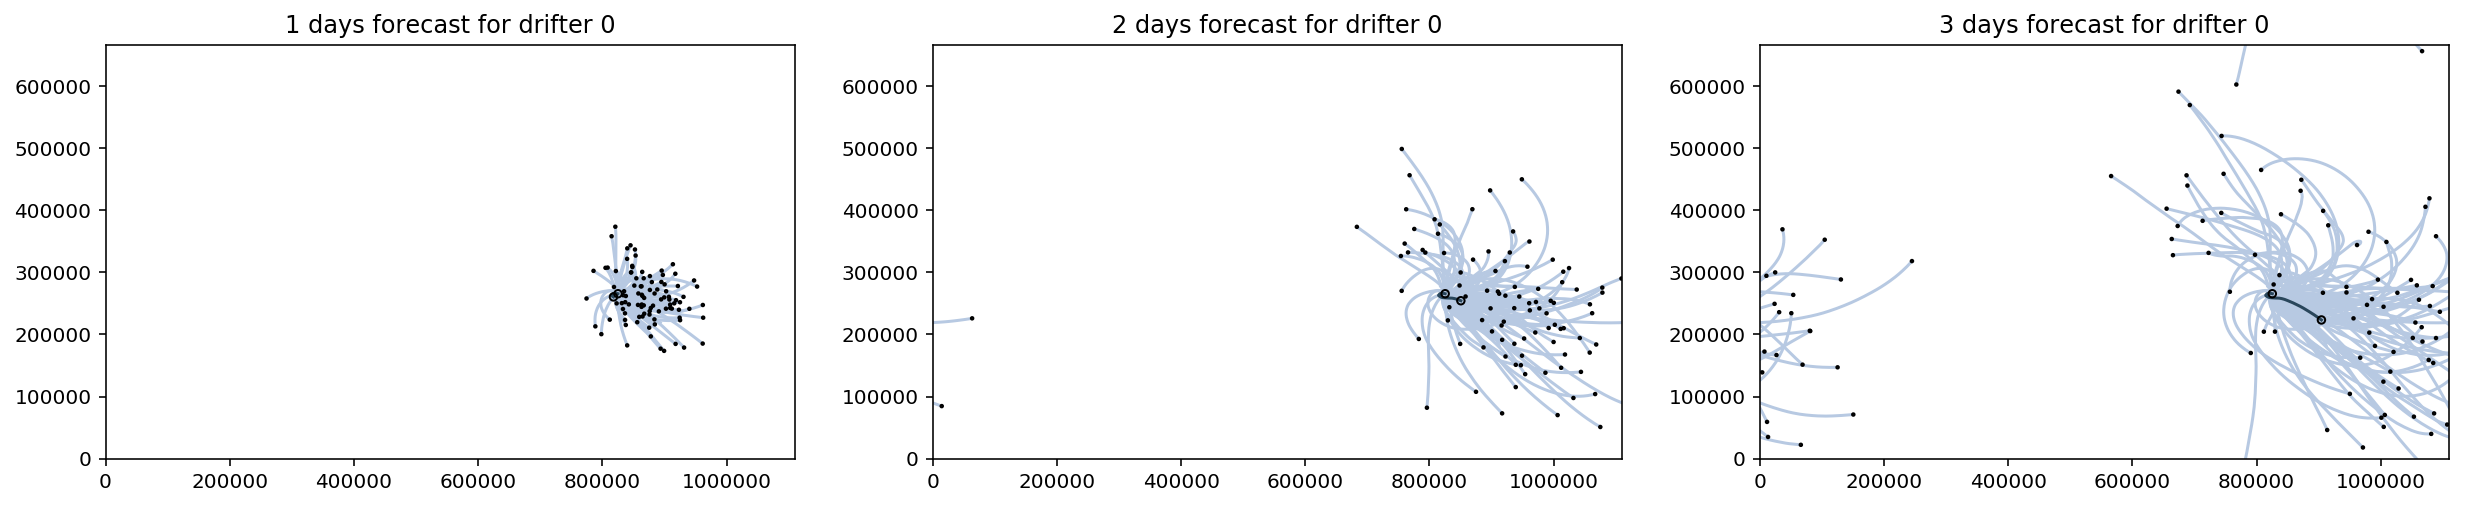

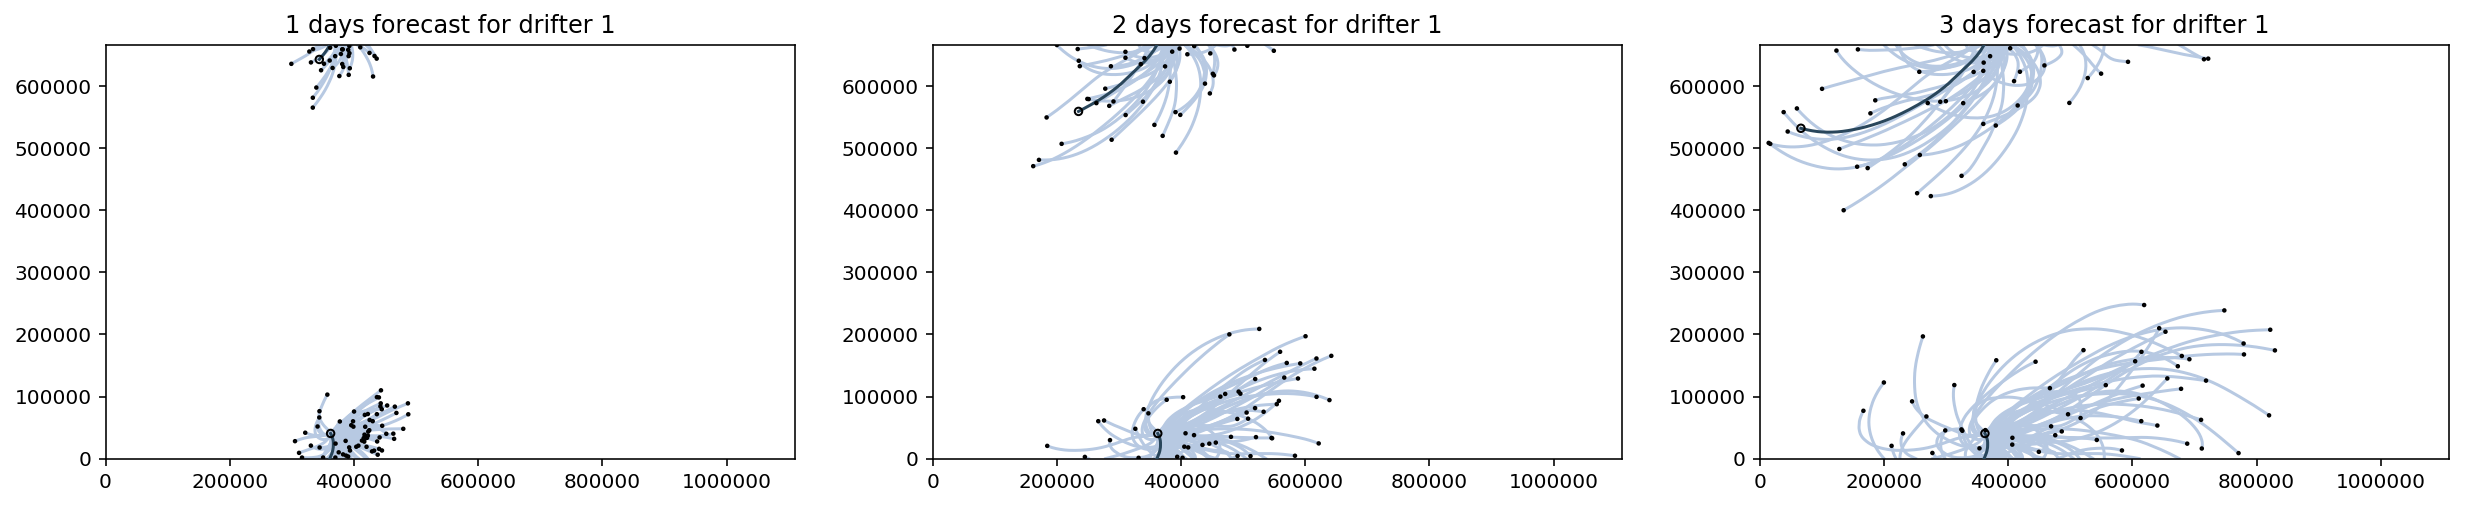

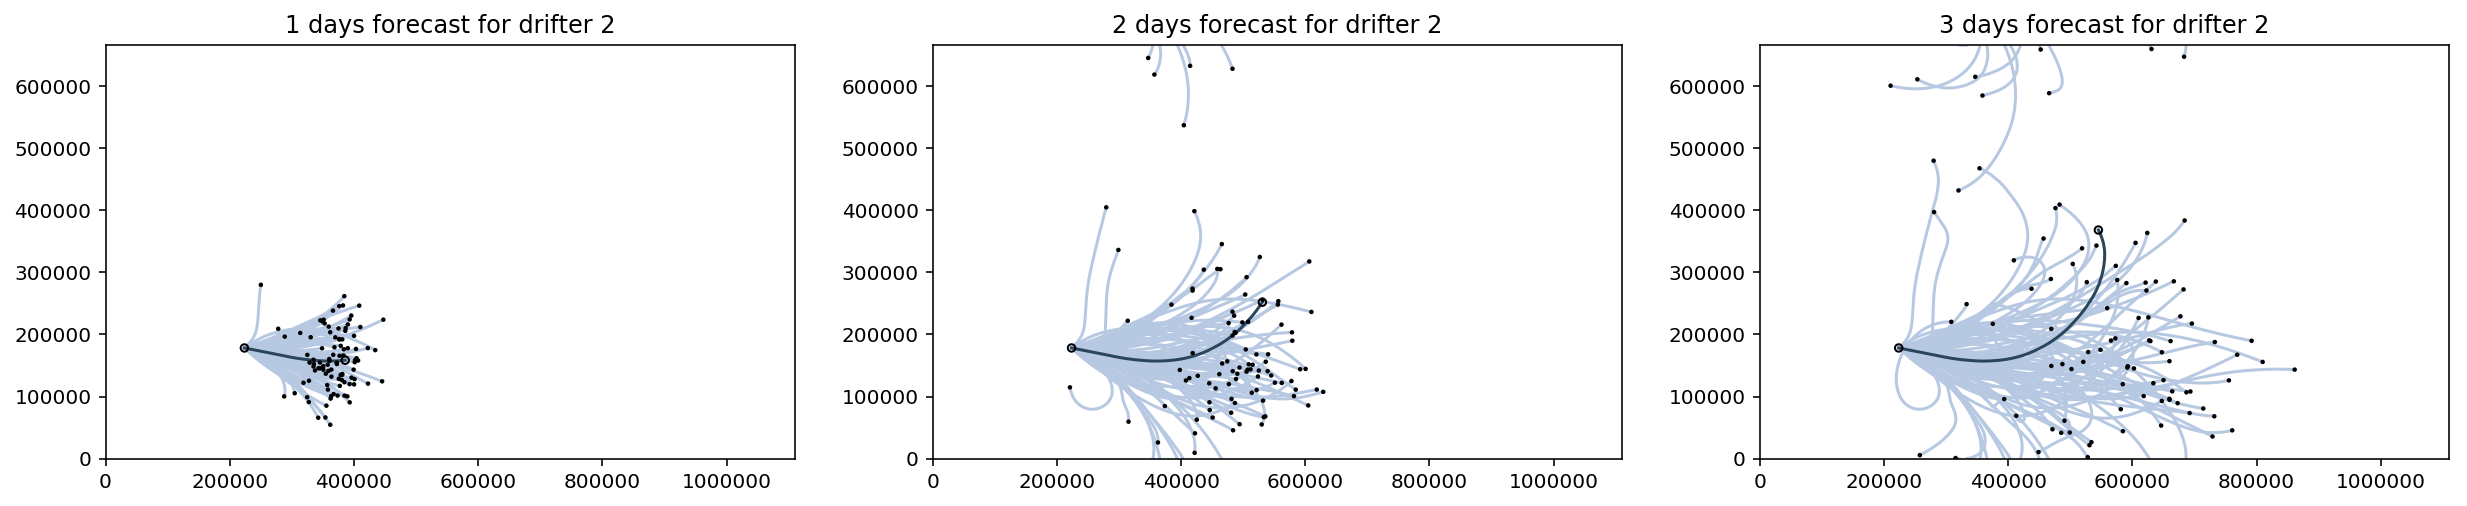

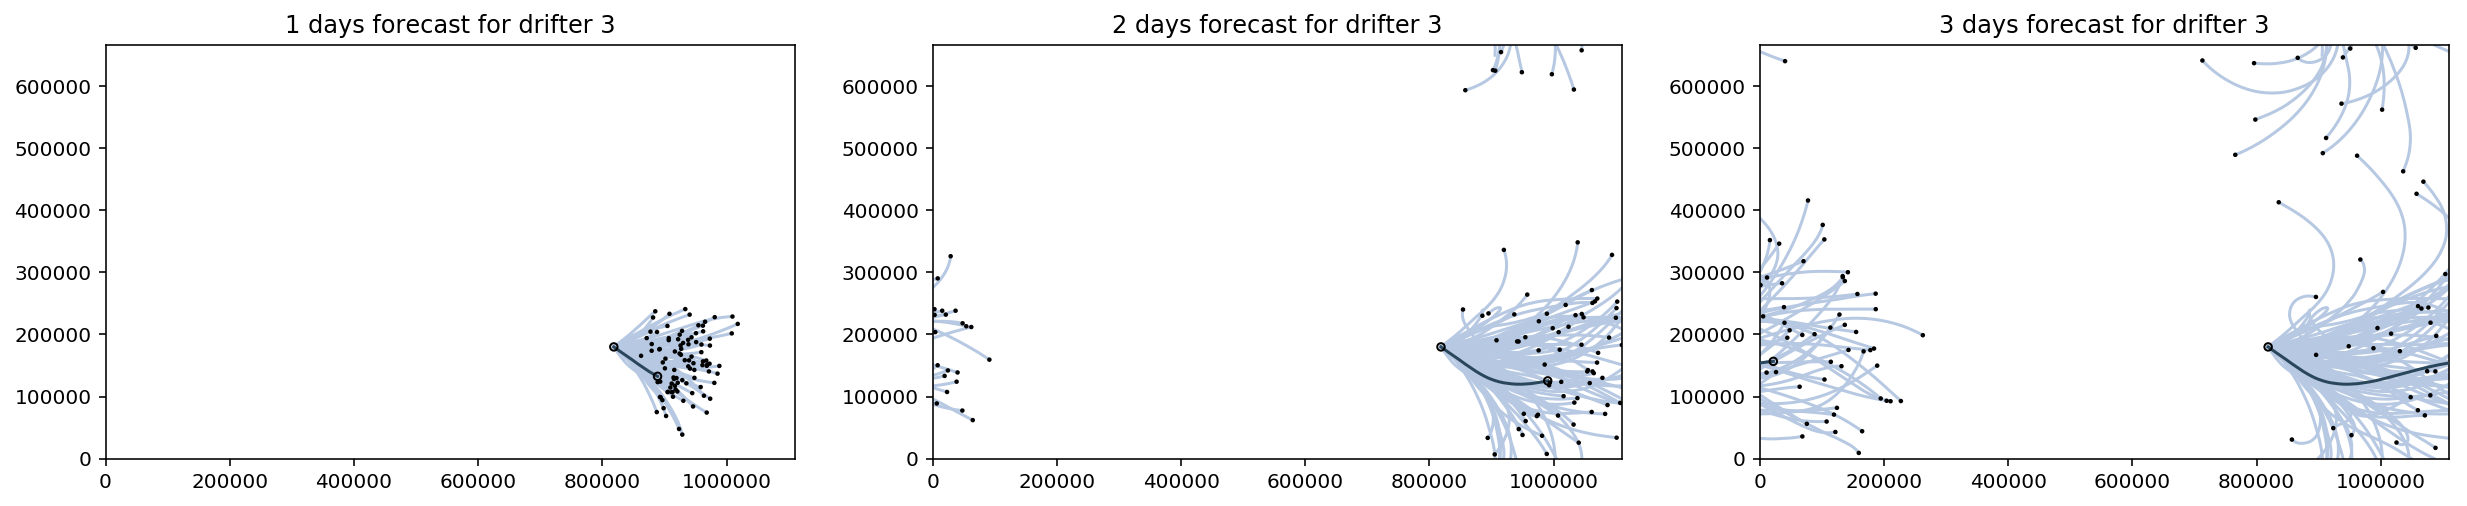

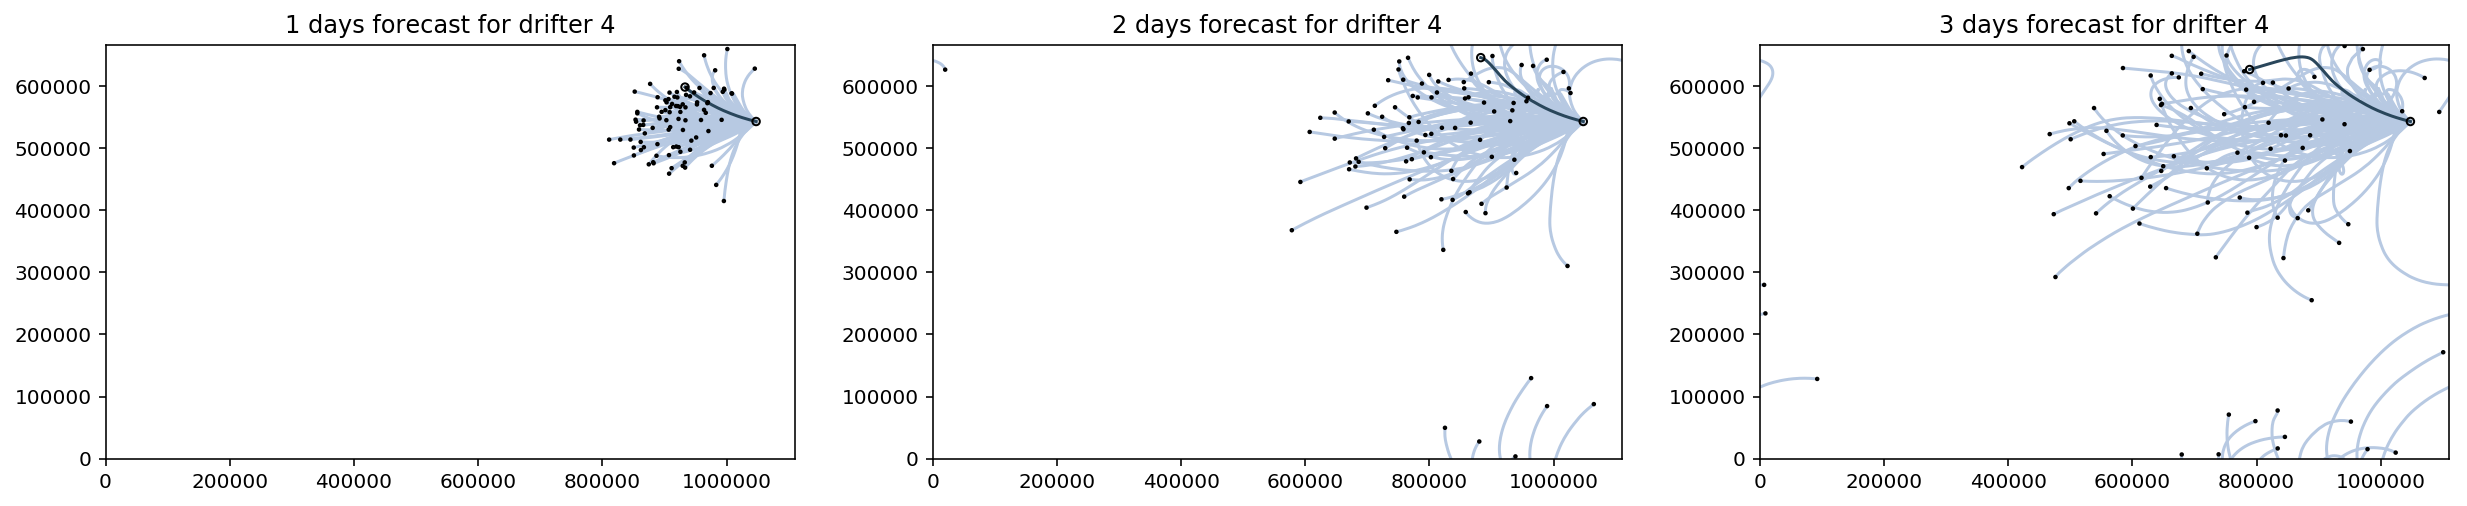

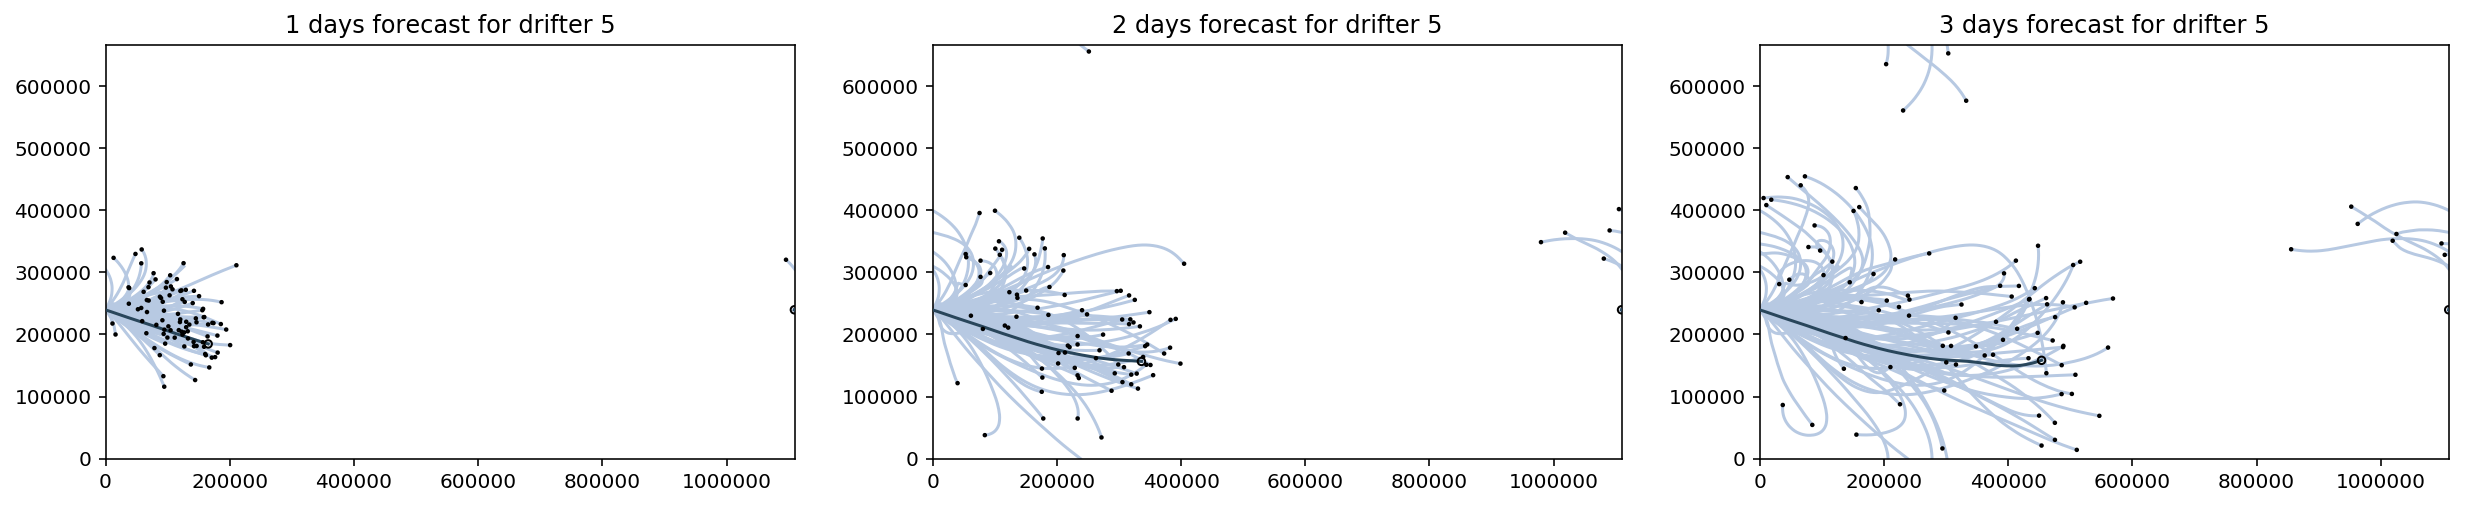

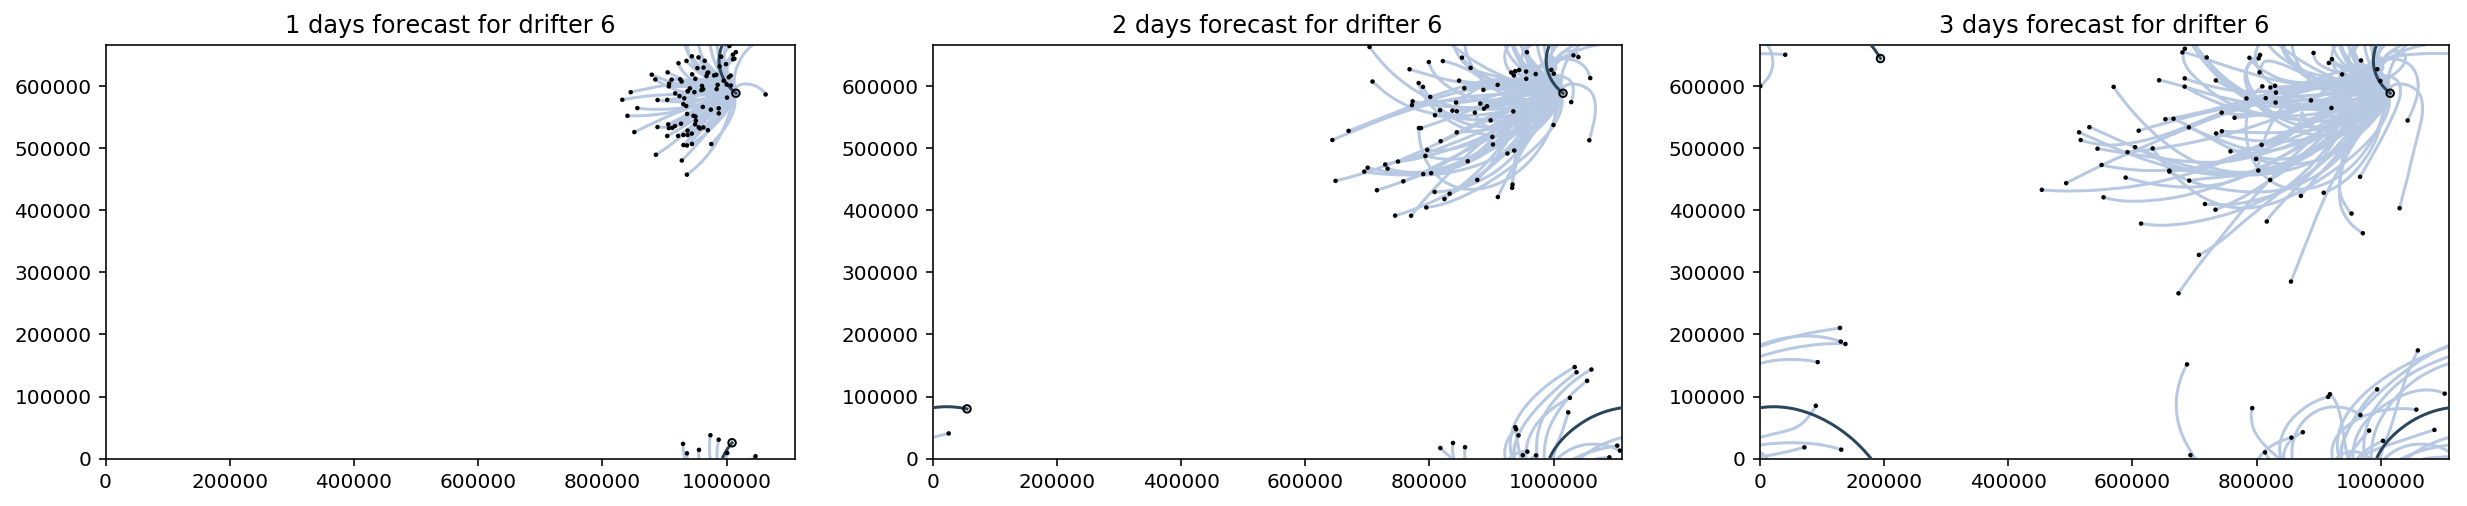

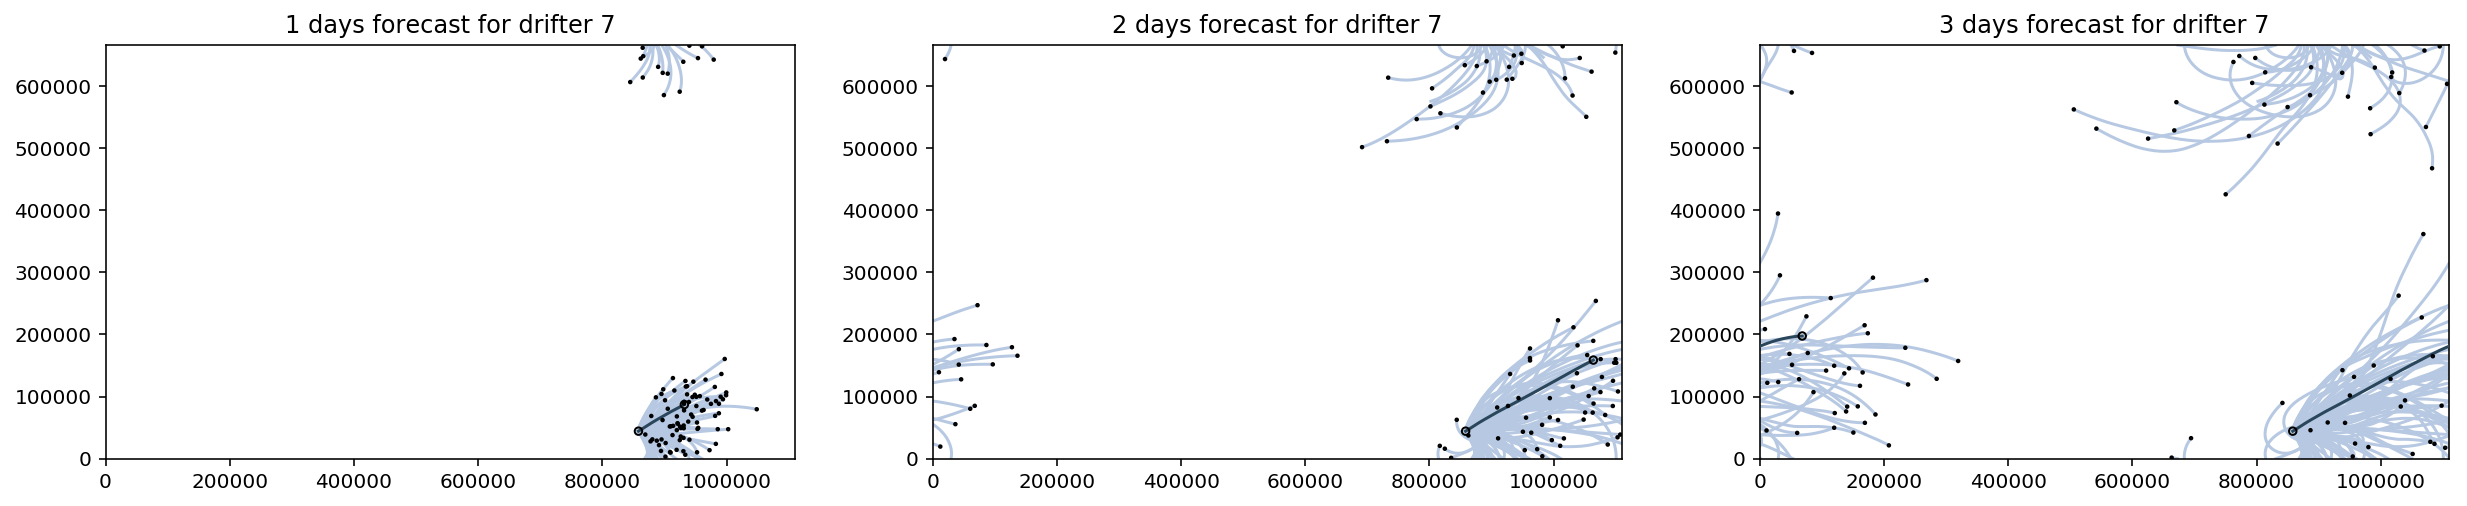

In [185]:
for drifter in range(len(drifterSet)):
    plotThreeDayForecast(true_observations, ensemble_observations, drifter)